<a href="https://colab.research.google.com/github/HyunsungJanetKim/python_ai_training/blob/AI_trainging_lv1/%EC%BD%94%EB%A1%9C%EB%82%98X_ray_ImageClassification_%EC%8B%A4%EC%8A%B5_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##흉부 X-ray이미지로 정상/코로나/폐렴을 구분하는 Image Classification실습

##1. 라이브러리 불러오기

In [ ]:
import os
import copy
import random

import cv2
import torch
import numpy as np
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from ipywidgets import interact

random_seed = 2022
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

##2. 이미지 파일경로 불러오기

In [ ]:
def list_image_files(data_dir, sub_dir):
    image_format = ["jpeg", "jpg", "png"]

    image_files = []
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split(".")[-1] in image_format:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files
#.으로 구분 된 것 중 맨끝이 이미지포맷(jpeg,jpg,png)이면
#sub_dir(Normal, Covid, Viral Pneumonia) 이미지파일을 리스트에 붙임

#os 모듈을 이용해서 경로명 간편하게 처리하는 방법
#import os
#print("join(): " + os.path.join("/A/B/C", "file.py"))
#실행 결과 : join(): /A/B/C/file.py

In [ ]:
data_dir = "/content/drive/MyDrive/facamdata/DATASET/Classification/train/"

normals_list = list_image_files(data_dir, "Normal")
covids_list = list_image_files(data_dir, "Covid")
pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")

In [ ]:
print(f"Normal:{len(normals_list)}, Covid:{len(covids_list)}, Pneumonia:{len(pneumonias_list)}")
#리스트의 길이 확인

Normal:70, Covid:111, Pneumonia:70


##3. 이미지파일을 RGB 3차원 배열로 불러오기

In [ ]:
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

##4. 이미지데이터 확인하기

In [ ]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))

#인터렉티브(interactive) 기능을 추가하거나 시각화하는데 사용되는 패키지를 사용해
#간단히 Jupyter Notebook에서 입력값과 출력값을 상호작용
#아래 스크롤 움직이면 해당번호에 해당하는 3개 이미지 출력됨. 
#Covid 이미지만 많아서 미니멈파일로 최대 70개까지 3개 비교가능하게 만들었음.
@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])

    plt.figure(figsize=(12,8))
    plt.subplot(131)  #plt.subplt(1,3,1)과 같음 1*3만들고 첫번째칸
    plt.title("Normal")
    plt.imshow(normal_image)
    plt.subplot(132)
    plt.title("Covid")
    plt.imshow(covid_image)
    plt.subplot(133)
    plt.title("Pneumonia")
    plt.imshow(pneumonia_image)
    plt.tight_layout

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

##5. 학습데이터셋 클래스 구축

In [ ]:
train_data_dir = "/content/drive/MyDrive/facamdata/DATASET/Classification/train/"
class_list = ["Normal", "Covid", "Viral Pneumonia"]

In [ ]:
#self는 class 전체에서 작용함
class Chest_dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        normals = list_image_files(data_dir, "Normal")
        covids = list_image_files(data_dir, "Covid")
        pneumonias = list_image_files(data_dir, "Viral Pneumonia")

        self.files_path = normals + covids + pneumonias
        self.transform = transform
    
    def __len__(self):
        return len(self.files_path)
        
    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = class_list.index(self.files_path[index].split(os.sep)[-2])

        target = class_list.index(self.files_path[index].split(os.sep)[0])

        if self.transform:
            image = self.transform(image)
            target = torch.Tensor([target]).long()

        return {"image":image, "target":target}

In [ ]:
dset = Chest_dataset(train_data_dir)

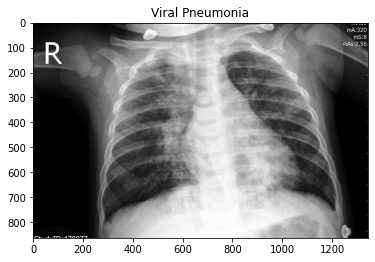

In [ ]:
index = 250
plt.title(class_list[dset[index]["target"]])
plt.imshow(dset[index]["image"])
#index값을 0~250으로 조정하면 모든 이미지파일 조회가능. 노멀/코로나/폐렴 순서대로

##6. 배열을 연산가능한 텐서로 변환하기

In [ ]:
transformer = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Resize((224, 224)),
                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                       std=[0.5, 0.5, 0.5]) #RGB값 0~1로 노멀라이즈
])

In [ ]:
train_dset = Chest_dataset(train_data_dir, transformer)

In [ ]:
index = 200
image = train_dset[index]["image"]
label = train_dset[index]["target"]

In [ ]:
print(image.shape, label)
#RGB, 가로, 세로
#tensor 0 정상 1 코로나 2 폐렴

torch.Size([3, 224, 224]) tensor([2])


##7. 데이터로더 구현하기

In [ ]:
def build_dataloader(train_data_dir, val_data_dir):
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    dataloaders["train"] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)

    val_dset = Chest_dataset(val_data_dir, transformer)
    dataloaders["val"] = DataLoader(val_dset, batch_size=1, shuffle=False, drop_last=False)
    return dataloaders

In [ ]:
train_data_dir = "/content/drive/MyDrive/facamdata/DATASET/Classification/train/"
val_data_dir = "/content/drive/MyDrive/facamdata/DATASET/Classification/test/"
dataloaders = build_dataloader(train_data_dir, val_data_dir)

In [ ]:
for i, d in enumerate(dataloaders["train"]):
    if i == 0:
        break

In [ ]:
d["target"].shape

torch.Size([4, 1])

In [ ]:
d["target"].squeeze()
#트레인 데이터는 4개씩 셔플되어서 뽑힘 for문 실행하면 반복됨. 

tensor([2, 1, 2, 0])

##8.Classification 모델(VGG19) 불러오기

In [ ]:
model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224), batch_size=1, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

##9. 데이터에 맞도록 모델 Head부분 변경하기

###맨밑에서 8번째줄
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0,1),
    nn.Linear(256, len(class_list)),
    nn.Sigmoid()
)

In [ ]:
#from torchsummary import summary
#summary(model, (3, 224, 224), batch_size=1, device="cuda")으로 확인할 수 있음

In [ ]:
def build_vgg19_based_model(device_name="cpu"):
    device = torch.device(device_name)
    model = models.vgg19(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, len(class_list)),
        nn.Softmax(dim=1)
    )
    return model.to(device)

In [ ]:
model = build_vgg19_based_model(device_name = "cpu")

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224), batch_size=1, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

##10. 손실함수 불러오기

In [ ]:
loss_func = nn.CrossEntropyLoss(reduction="mean")

## 11. Gradient 최적화 함수 불러오기

In [ ]:
optimaizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)

##12. 모델 검증을 위한 Accuracy 생성하기

In [ ]:
@torch.no_grad()
def get_accuracy(image, target, model):
    batch_size = image.shape[0]
    prediction = model(image)
    _, pred_label = torch.max(prediction, dim=1)
    is_correct = (pred_label == target)
    return is_correct.cpu().numpy().sum() / batch_size

##13. 모델 학습을 위한 함수 구현하기

In [ ]:
device = torch.device("cpu")

In [ ]:
def train_one_epoch(dataloaders, model, optimizer, loss_func, device):
    losses = {}
    accuracies = {}
    for phase in ["train", "val"]:
        running_loss = 0.0
        running_correct = 0

        if phase == "train":
            model.train()
        else:
            model.eval()

        for index, batch in enumerate(dataloaders[phase]):
            image = batch["image"].to(device)
            target = batch["target"].squeeze(1).to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                prediction = model(image)
                loss = loss_func(prediction, target)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            running_correct += get_accuracy(image, target, model)

            if phase == "train":
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders[phase])} - Running loss: {loss.item()}")

        losses[phase] = running_loss / len(dataloaders[phase])
        accuracies[phase] = running_correct / len(dataloaders[phase])
    return losses, accuracies

In [ ]:
def save_best_model(model_state, model_name, save_dir="/content/drive/MyDrive/facamdata/DATASET/Classification/trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

##14. 모델 학습 수행하기

In [ ]:
device= torch.device("cuda")

train_data_dir = "/content/drive/MyDrive/facamdata/DATASET/Classification/train/"
val_data_dir = "/content/drive/MyDrive/facamdata/DATASET/Classification/test/"

dataloaders = build_dataloader(train_data_dir, val_data_dir)
model = build_vgg19_based_model("cuda")
loss_func = nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)


In [ ]:
#optimizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)
#디버깅 할 때는 에러난 행만 따로 빼서 돌려보고, 원인 수정하기 오탈자인 경우가 가장 많다.

In [ ]:
def train_one_epoch(dataloaders, model, optimizer, loss_func, device):
    losses = {}
    accuracies = {}

    for phase in ["train", "val"]:
        running_loss = 0.0
        running_correct = 0

        if phase == "train":
            model.train()
        else:
            model.eval()

        for index, batch in enumerate(dataloaders[phase]):
            image = batch[0].to(device)
            target = batch[1].squeeze(dim=1).to(device)

            with torch.set_grad_enabled(phase == "train"):
                prediction = model(image)
                loss = loss_func(prediction, target)
                                 
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            running_correct += get_accuracy(image, target, model)

            if phase == "train":
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")

        losses[phase] = running_loss / len(dataloaders[phase])
        accuracies[phase] = running_correct / len(dataloaders[phase])
    return losses, accuracies

In [ ]:
num_epochs = 10

best_acc = 0.0
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_accuracy.append(accuracies["train"])
    val_accuracy.append(accuracies["val"])

    print(f"{epoch+1}/{num_epochs}-Train Loss: {losses['train']}, Val Loss: {losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc: {accuracies['train']}, Val Acc: {accuracies['val']}")

    if (epoch > 3) and (accuracies["val"] > best_acc):
        best_acc = accuracies["val"]
        best_model = copy.deepcopy(model.state_dict())
        save_best_model(best_model, f"model_{epoch+1:02d}.pth")

print(f"Best Accuracy: {best_acc}")

0/62 - Running loss: 1.1031759977340698
10/62 - Running loss: 1.0950886011123657
20/62 - Running loss: 1.0661633014678955
30/62 - Running loss: 1.0662105083465576
40/62 - Running loss: 1.087852954864502
50/62 - Running loss: 1.0340864658355713
60/62 - Running loss: 0.9278405904769897
1/10-Train Loss: 1.0698882091429927, Val Loss: 1.024732543663545
1/10-Train Acc: 0.6491935483870968, Val Acc: 0.6212121212121212
0/62 - Running loss: 0.957683265209198
10/62 - Running loss: 0.8969007730484009
20/62 - Running loss: 0.6826238036155701
30/62 - Running loss: 0.6580622792243958
40/62 - Running loss: 0.5937819480895996
50/62 - Running loss: 0.9966844320297241
60/62 - Running loss: 0.6259006261825562
2/10-Train Loss: 0.8501815459420604, Val Loss: 0.8690751068519823
2/10-Train Acc: 0.7782258064516129, Val Acc: 0.6818181818181818
0/62 - Running loss: 0.6959230899810791
10/62 - Running loss: 1.001394510269165
20/62 - Running loss: 0.6178486943244934
30/62 - Running loss: 0.8148432970046997
40/62 - R

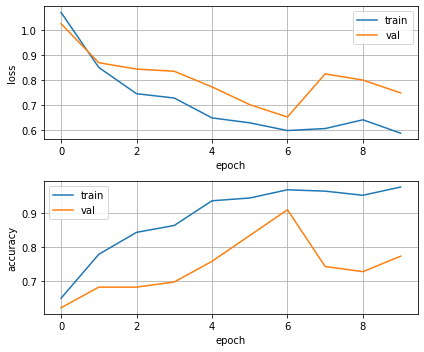

In [ ]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()
plt.tight_layout()